In [78]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
def get_data(ticker, start, end, interval="1d"):
    """
    Downloads historical data.
    """
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)

    # Handle multi-index columns if yfinance returns them
    if isinstance(df.columns, pd.MultiIndex):
        try:
            # Try to select the 'Close' column for the specific ticker
            # If the multi-index is (Price, Ticker), we need to be careful
            if 'Close' in df.columns.levels[0]:
                 df = df['Close']
            else:
                 # Fallback: just take the first column if structure is unexpected
                 df = df.iloc[:, 0].to_frame(name='Close')
        except:
             df = df.iloc[:, 0].to_frame(name='Close')
    else:
        # Standard dataframe
        if 'Close' in df.columns:
            df = df[['Close']]
        else:
             # Fallback if 'Close' isn't exact match (e.g. 'Adj Close')
             df = df.iloc[:, 0].to_frame(name='Close')

    # Ensure column is named 'Close' for the rest of the script
    df.columns = ['Close'] if len(df.columns) == 1 else df.columns
    return df.dropna()

In [80]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np

def get_macro_data(start_date, end_date):
    """
    Fetches GDP and Current Account (Trade Proxy) for US and Euro Area.
    Uses a 'Net Score' approach to avoid conflicting signals.
    """
    print("Fetching Macro Data (GDP + Current Account)...")

    # 1. DEFINE TICKERS
    tickers = {
        'US_GDP':    'GDP',                # US GDP (Billions $)
        'EU_GDP':    'CLVMNACSCAB1GQEU28', # Euro Area GDP (Real, Index)

        # US Current Account (Billions $)
        'US_CA':     'IEABC',
        # Euro Area Current Account (% of GDP) - THIS IS THE WORKING TICKER
        'EU_CA_Pct': 'EA19B6BLTT02STSAQ',
    }

    try:
        data = web.DataReader(list(tickers.values()), 'fred', start_date, end_date)
        data.columns = list(tickers.keys())
        data = data.resample('D').ffill()

        # 2. NORMALIZE DATA (Apples to Apples)

        # A. GDP Growth (Year over Year)
        # We use 252 days (1 trading year) to smooth out noise
        data['US_Growth'] = data['US_GDP'].pct_change(252)
        data['EU_Growth'] = data['EU_GDP'].pct_change(252)

        # B. Current Account (Convert US to % of GDP to match EU)
        # Formula: (Net Foreign Investment / GDP) * 100
        data['US_CA_Pct'] = (data['US_CA'] / data['US_GDP']) * 100

        # 3. CALCULATE SCORES

        # Score 1: Growth Differential (If EU grows faster -> Positive Score)
        data['Growth_Diff'] = data['EU_Growth'] - data['US_Growth']

        # Score 2: Trade Differential (If EU runs larger surplus -> Positive Score)
        data['Trade_Diff'] = data['EU_CA_Pct'] - data['US_CA_Pct']

        # 4. FINAL SIGNAL (Weighted Sum)
        # We give equal weight to Growth and Trade.
        # If Total > 0, Fundamentals favor EUR.
        data['Total_Score'] = data['Growth_Diff'] + data['Trade_Diff']

        # Create Binary Signal for the strategy
        # 1 = Bullish EUR, -1 = Bearish EUR (Long USD)
        data['Macro_Signal'] = np.where(data['Total_Score'] > 0, 1, -1)

        print("Macro Data fetched successfully.")
        print(f"Signal Distribution: \n{data['Macro_Signal'].value_counts()}")

        return data[['Macro_Signal']]

    except Exception as e:
        print(f"Error: {e}")
        # Fallback: Return all 1s (Long Only) if data fails, just to keep code running
        print("Using Fallback Signal (1).")
        dates = pd.date_range(start=start_date, end=end_date)
        return pd.DataFrame({'Macro_Signal': 1}, index=dates)

In [81]:
def calculate_metrics(equity_curve, trade_log):
    """
    Computes performance metrics including Avg Win/Loss Ratio.

    Parameters:
    - equity_curve: Pandas Series representing the account balance over time.
    - trade_log: Can be a list/Series of PnL values OR a DataFrame with 'Entry_Price' and 'Exit_Price'.
    """

    # --- 1. Pre-process trade_log to ensure we have a list of PnL values ---
    if isinstance(trade_log, pd.DataFrame):
        # If it's a DataFrame and PnL is missing, create it
        if 'pnl' not in trade_log.columns:
            try:
                # Assuming standard column names; adjust if yours differ (e.g. 'Close', 'Open')
                pnl_values = trade_log['Exit_Price'] - trade_log['Entry_Price']
            except KeyError:
                print("Error: DataFrame missing 'Exit_Price' or 'Entry_Price'.")
                pnl_values = []
        else:
            pnl_values = trade_log['pnl']

        # Convert to list for the logic below
        trades = pnl_values.tolist()
    else:
        # Assume it's already a list/Series of PnL values
        trades = list(trade_log)

    # --- 2. Existing Metrics Logic ---
    daily_returns = equity_curve.pct_change().dropna()
    total_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    days = (equity_curve.index[-1] - equity_curve.index[0]).days
    annual_return = ((1 + total_return) ** (365.0 / max(1, days))) - 1
    annual_volatility = daily_returns.std() * np.sqrt(252)

    if annual_volatility == 0:
        sharpe_ratio = 0
    else:
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # --- 3. Win/Loss Analysis ---
    if len(trades) > 0:
        winners = [t for t in trades if t > 0]
        losers = [t for t in trades if t < 0]

        hit_rate = len(winners) / len(trades)

        avg_win = np.mean(winners) if winners else 0
        avg_loss = np.mean(losers) if losers else 0

        # Calculate Ratio (Use abs to keep ratio positive: e.g. 100 / |-50| = 2.0)
        if avg_loss != 0:
            win_loss_ratio = avg_win / abs(avg_loss)
        else:
            win_loss_ratio = 0 # Or np.inf if you prefer
    else:
        hit_rate = 0.0
        avg_win = 0.0
        avg_loss = 0.0
        win_loss_ratio = 0.0

    return {
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Hit Rate": hit_rate,
        "Total Trades": len(trades),
        "Avg Win": avg_win,
        "Avg Loss": avg_loss,
        "Win/Loss Ratio": win_loss_ratio
    }

In [82]:
def run_strategy(data, macro_df, alpha, beta, threshold=0.001, decel_rate=0.0005, initial_capital=10000):
    df = data.copy()

    # 1. Indicators
    df['es_slow'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()
    df['es_fast'] = df['Close'].ewm(alpha=beta, adjust=False).mean()
    df['diff'] = df['es_fast'] - df['es_slow']
    df['velocity'] = df['es_fast'].diff()
    df['acceleration'] = df['velocity'].diff()

    # Join Macro Data (Assumes macro_df has a column 'Macro_Signal' with 1, -1, or 0)
    df = df.join(macro_df[['Macro_Signal']], how='left').ffill()

    # 2. Variables
    position = 0
    entry_price = 0.0
    equity = [initial_capital] * len(df)
    trade_log = []
    trade_dates = []
    trade_types = []
    trade_prices = []

    # 3. Loop
    for i in range(2, len(df)):
        curr_price = df['Close'].iloc[i]
        prev_price = df['Close'].iloc[i-1]
        date = df.index[i]

        curr_diff = df['diff'].iloc[i]
        prev_diff = df['diff'].iloc[i-1]
        curr_accel = df['acceleration'].iloc[i]

        # Get Macro Signal (1=Bullish, -1=Bearish, 0=Neutral)
        macro_signal = df['Macro_Signal'].iloc[i]

        # A. Mark-to-Market (Calculate PnL for open positions)
        if position == 1:
            pct_change = (curr_price - prev_price) / prev_price
            equity[i] = equity[i-1] * (1 + pct_change)
        elif position == -1:
            pct_change = (prev_price - curr_price) / prev_price
            equity[i] = equity[i-1] * (1 + pct_change)
        else:
            equity[i] = equity[i-1]

        # B. Exit (Deceleration)
        # Note: Exits generally disregard macro. If momentum dies, get out.
        if position == 1 and curr_accel < -decel_rate:
            trade_log.append(curr_price - entry_price)
            position = 0
            # Optional: Add Exit to trade df for visualization
            trade_dates.append(date)
            trade_types.append('Exit Long')
            trade_prices.append(curr_price)

        elif position == -1 and curr_accel > decel_rate:
            trade_log.append(entry_price - curr_price)
            position = 0
            # Optional: Add Exit to trade df
            trade_dates.append(date)
            trade_types.append('Exit Short')
            trade_prices.append(curr_price)

        # C. Entry (Technical + Macro Confirmation)
        # Only enter if position is currently flat (0) or if reversing (handled below)

        # --- LONG ENTRY ---
        # Technical: Crossover Up AND Macro: Bullish (Signal > 0)
        if prev_diff < 0 and curr_diff > threshold and macro_signal > 0:
            if position == -1: # Close existing short first
                trade_log.append(entry_price - curr_price)

            position = 1
            entry_price = curr_price
            trade_dates.append(date)
            trade_types.append('Buy')
            trade_prices.append(curr_price)

        # --- SHORT ENTRY ---
        # Technical: Crossover Down AND Macro: Bearish (Signal < 0)
        elif prev_diff > 0 and curr_diff < -threshold and macro_signal < 0:
            if position == 1: # Close existing long first
                trade_log.append(curr_price - entry_price)

            position = -1
            entry_price = curr_price
            trade_dates.append(date)
            trade_types.append('Sell')
            trade_prices.append(curr_price)

    df['Equity'] = equity

    # Safety check for empty trade_log before calculating metrics
    if not trade_log:
        trade_log = [0] # Avoid empty list errors

    metrics = calculate_metrics(pd.Series(df['Equity']), trade_log)
    trades_df = pd.DataFrame({'Date': trade_dates, 'Type': trade_types, 'Price': trade_prices})

    return metrics, df, trades_df

In [83]:
def perform_grid_search(data, macro_df, threshold_input, decel_input, step=0.0005):
    """
    Finds optimal Alpha/Beta based on Sharpe Ratio.
    Now accepts user-defined threshold and deceleration.
    """
    r = np.arange(step, 1.0, step)
    results = []

    print(f"Scanning parameters (Step: {step})...")

    best_sharpe = -np.inf
    best_returns = -np.inf
    best_params = {}

    for alpha in r:
        for beta in r:
            if alpha >= beta: continue

            # Pass the user inputs here
            metrics, _, _ = run_strategy(data, macro_df, alpha, beta, threshold=threshold_input, decel_rate=decel_input)

            results.append({
                'alpha': round(alpha, 2),
                'beta': round(beta, 2),
                'Sharpe': metrics['Sharpe Ratio']
            })

            if metrics['Sharpe Ratio'] > best_sharpe:
                best_sharpe = metrics['Sharpe Ratio']
                best_params = {'alpha': alpha, 'beta': beta}

    results_df = pd.DataFrame(results)
    heatmap_data = results_df.pivot(index='alpha', columns='beta', values='Sharpe')

    return heatmap_data, best_params

In [84]:
def plot_heatmap(heatmap_data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
    plt.title("Strategy Sharpe Ratio Heatmap")
    plt.ylabel("Alpha (Slow)")
    plt.xlabel("Beta (Fast)")
    plt.gca().invert_yaxis()
    plt.show()

def plot_trades(df, trade_log):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

    # Plot 1: Price and Signals
    ax1.plot(df.index, df['Close'], label='Price', color='black', alpha=0.3)
    ax1.plot(df.index, df['es_slow'], label='ES Slow', color='blue', alpha=0.6)
    ax1.plot(df.index, df['es_fast'], label='ES Fast', color='orange', alpha=0.6)

    buys = trade_log[trade_log['Type'] == 'Buy']
    ax1.scatter(buys['Date'], buys['Price'], marker='^', color='green', s=100, label='Buy', zorder=5)

    sells = trade_log[trade_log['Type'] == 'Sell']
    ax1.scatter(sells['Date'], sells['Price'], marker='v', color='red', s=100, label='Sell', zorder=5)

    ax1.set_title("Price, Indicators & Trades")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Equity Curve
    ax2.plot(df.index, df['Equity'], color='purple', label='Strategy Equity')
    ax2.set_title("Equity Curve")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [85]:
def visualize_performance(equity_curve, trade_log):
    # Ensure trades are a list of numbers for plotting (same logic as above)
    if isinstance(trade_log, pd.DataFrame):
        if 'pnl' in trade_log.columns:
            trades = trade_log['pnl'].tolist()
        else:
            trades = (trade_log['Exit_Price'] - trade_log['Entry_Price']).tolist()
    else:
        trades = list(trade_log)

    # Create the figure
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2)

    # Plot 1: Equity Curve (Top, spanning full width)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(equity_curve.index, equity_curve, label='Equity', color='blue', linewidth=1.5)
    ax1.set_title("Equity Curve")
    ax1.set_ylabel("Account Balance ($)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Scatter of Wins/Losses (Bottom Left)
    ax2 = fig.add_subplot(gs[1, 0])
    colors = ['green' if t > 0 else 'red' for t in trades]
    ax2.scatter(range(len(trades)), trades, c=colors, alpha=0.6)
    ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_title("Individual Trade PnL Sequence")
    ax2.set_xlabel("Trade #")
    ax2.set_ylabel("PnL ($)")

    # Plot 3: Histogram of PnL (Bottom Right)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(trades, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax3.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax3.set_title("PnL Distribution")
    ax3.set_xlabel("PnL ($)")

    plt.tight_layout()
    plt.show()

Fetching Macro Data (GDP + Current Account)...


/tmp/ipython-input-3665040840.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
/tmp/ipython-input-4276501897.py:33: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['EU_Growth'] = data['EU_GDP'].pct_change(252)


Macro Data fetched successfully.
Signal Distribution: 
Macro_Signal
-1    367
Name: count, dtype: int64
Scanning parameters (Step: 0.05)...

Optimal Parameters Found:
Alpha: 0.05
Beta:  0.85


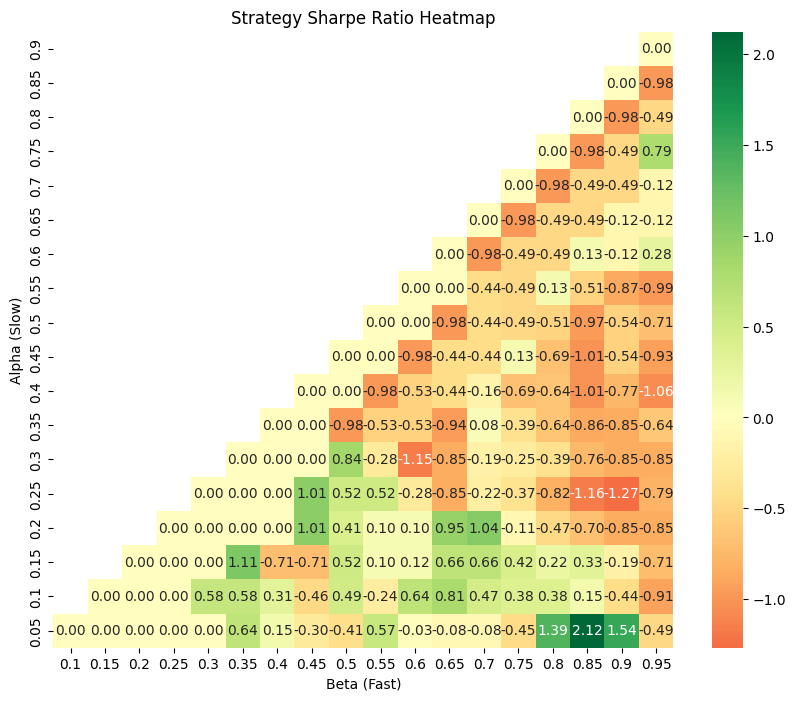


--- PERFORMANCE METRICS ---
Annual Return:     1.93%
Annual Volatility: 0.87%
Sharpe Ratio:      2.1223
Max Drawdown:      -0.36%
Hit Rate:          100.00%
Total Trades:      3
Avg Win:           0.006978909174601237
Avg Loss:          0
Win/Loss Ratio:    0.00


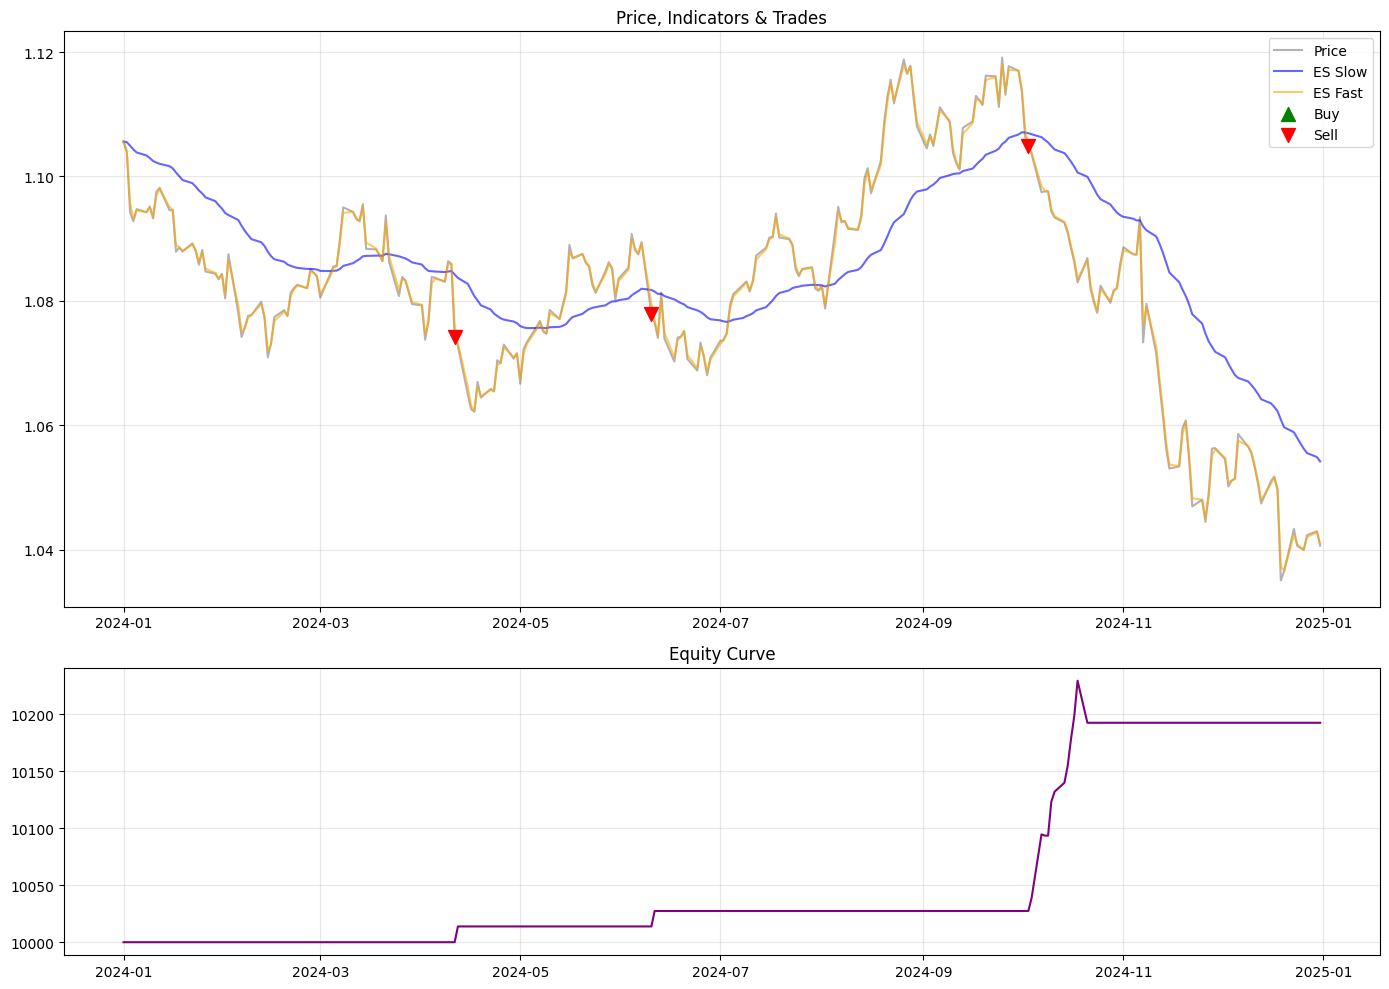

In [86]:
from typing_extensions import deprecated
# 1. Define Ticker and Dates
TICKER = "EURUSD=X" # FX Pair
START = "2024-01-01"
END = "2025-01-01"
threshold = 0.0015
deceleration = 0.005 # exit strategy. Price per Day squared


try:
    # 1. Load Data
  print(f"Downloading {TICKER}...")
  data = get_data(TICKER, START, END, "1d")
  macro_data = get_macro_data(START, END)

  if data.empty:
      print("No data found. Check ticker or dates.")
  else:            # 2. Run Grid Search (Passing your inputs)
      heatmap_matrix, best_params = perform_grid_search(
          data,
          macro_data,
          threshold_input=threshold,
          decel_input=deceleration,
          step=0.05
      )

      if not best_params:
            print("Grid search failed to find valid parameters (possibly all Sharpe Ratios were NaN or negative).")
      else:
            print(f"\nOptimal Parameters Found:")
            print(f"Alpha: {best_params['alpha']:.2f}")
            print(f"Beta:  {best_params['beta']:.2f}")

            plot_heatmap(heatmap_matrix)

                # 3. Run Final Strategy (Passing your inputs)
            final_metrics, final_df, final_trades = run_strategy(
                data,
                macro_data,
                best_params['alpha'],
                best_params['beta'],
                threshold=threshold,
                decel_rate=deceleration
            )

            # 4. Print Metrics
            print("\n--- PERFORMANCE METRICS ---")
            print(f"Annual Return:     {final_metrics['Annual Return']:.2%}")
            print(f"Annual Volatility: {final_metrics['Annual Volatility']:.2%}")
            print(f"Sharpe Ratio:      {final_metrics['Sharpe Ratio']:.4f}")
            print(f"Max Drawdown:      {final_metrics['Max Drawdown']:.2%}")
            print(f"Hit Rate:          {final_metrics['Hit Rate']:.2%}")
            print(f"Total Trades:      {final_metrics['Total Trades']}")
            print(f"Avg Win:           {final_metrics['Avg Win']}")
            print(f"Avg Loss:          {final_metrics['Avg Loss']}")
            print(f"Win/Loss Ratio:    {final_metrics['Win/Loss Ratio']:.2f}")

            # 5. Visualize
            plot_trades(final_df, final_trades)

except Exception as e:
    print(f"An error occurred: {e}")